In [1]:
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
from scipy.stats import poisson, expon
import math

The LOG variable is used to print information about packets' creation and receiving. It is used for debugging or getting more information about the process.

In [2]:
LOG = False

The Packet class is used to store information about packets. The packets are created in the SourceHost class and received in the DestinationHost class. The packets are stored in the Packet.packets list.
It has the following attributes:
- id - packet id
- src - source host id
- send_time - time when the packet was sent from the source host
- priority - packet priority
- dst - destination host id
- dst_arrival_time - time when the packet was received by the destination host
- wait_enqueue_time - time when the packet was added to the queue
- process_time - time when the packet was processed by the processor
- start_process_time - time when the packet was started to be processed by the processor
- processor_number - processor number which processed the packet. It starts from 0.

In [3]:
class Packet:
    packets = []

    @staticmethod
    def _get_priority():
        random_number = np.random.random()
        if random_number < 0.2:
            return 3
        elif random_number < 0.5:
            return 2
        elif random_number < 1.0:
            return 1
        else:
            raise ValueError(f'Random number is not in [0, 1) range: {random_number}')

    def __init__(self, src, send_time):
        self.id = len(Packet.packets)
        self.src = src
        self.send_time = send_time
        self.priority = Packet._get_priority()

        self.dst = None
        self.dst_arrival_time = None
        self.wait_enqueue_time = None
        self.process_time = None
        self.start_process_time = None
        self.processor_number = None

        Packet.packets.append(self)

    def __str__(self):
        return f'Packet {self.id} from {self.src} to {self.dst}'

    def set_dst(self, dst):
        self.dst = dst

    def set_dst_arrival_time(self, dst_arrival_time):
        self.dst_arrival_time = dst_arrival_time

    def set_wait_enqueue_time(self, wait_enqueue_time):
        self.wait_enqueue_time = wait_enqueue_time

    def set_process_time(self, process_time):
        self.process_time = process_time

    def set_start_process_time(self, start_process_time):
        self.start_process_time = start_process_time

    def set_processor_number(self, processor_number, processors_number):
        if processor_number < 0 or processor_number >= processors_number:
            raise ValueError(f'Wrong processor number: {processor_number}, processor_numbers: {processors_number}')

        self.processor_number = processor_number

The SourceHost class is used to create packets. It has the following methods:
- get_next_packet - returns the next packet which will be created. It also adds the packet to the SourceHost.packets list.


The DestinationHost class is used to receive packets. It has the following methods:
- receive_packet - receives the packet and adds it to the DestinationHost.packets list.

In [4]:
class SourceHost:
    def __init__(self, send_poisson_lambda):
        self.send_poisson_lambda = send_poisson_lambda
        self.host_id = 1
        self.packets = []

    def get_next_packet(self, current_time):
        # poisson distribution with lambda = poisson process distribution with 1 / lambda
        send_time = current_time + np.random.exponential(1 / self.send_poisson_lambda)
        packet = Packet(self.host_id, send_time)
        self.packets.append(packet)

        if LOG:
            print(f'Packet {packet.id} was created at {current_time} and will be sent at {send_time}')
        return packet


class DestinationHost:
    def __init__(self):
        self.host_id = 2
        self.packets = []

    def receive_packet(self, packet: Packet, current_time):
        packet.set_dst(self.host_id)
        packet.set_dst_arrival_time(current_time)

        calculated_end_process_time = packet.start_process_time + packet.process_time
        if calculated_end_process_time != packet.dst_arrival_time:
            raise ValueError(f'Packet {packet.id} has wrong information about end process time: '
                             f'end_process_time = {calculated_end_process_time}, '
                             f'dst_arrival_time = {packet.dst_arrival_time}')

        self.packets.append(packet)

        if LOG:
            print(f'Packet {packet.id} was received at {packet.dst_arrival_time}')

The Queue class is used to store packets. It is the base class for the FIFOQueue, WRRQueue and NPPSQueue classes.
It has the following methods:
- is_full - Returns True if the queue is full, False otherwise. If there are many queues, then we just check the related queue.
- is_empty - Returns True if the queue is empty, False otherwise. All queues should empty.
- add_packet - Adds the packet to the queue. If the queue is full, then it raises ValueError.
- get_next_waiting_packet - Returns the next packet which should be processed. If the queue is empty, then it raises ValueError.

Details in each class implementation.
FIFOQueue class is used to store packets in the FIFO order. It has the following methods (important methods):
- add_packet - Just append the packet to the end of the queue.
- get_next_waiting_packet - Just return the first packet from the queue and remove it from the queue.

WRRQueue class is used to store packets in the WRR order. It has the following methods (important methods):
- is_full - First we get the corresponding queue to the passed packet based on the packet priority. Then we check if the queue is full.
- add_packet - First we get the corresponding queue to the passed packet based on the packet priority. If the queue is full, then it raises ValueError. Otherwise, we append the packet to the end of the queue.
- get_next_waiting_packet - First if all weights are applied, we reset the weights of queues. Then we get the packet from the queue which is its turn. If the queue was empty, we process to the next queue which is non-empty and its weight is not full. If all queues are empty, then it raises ValueError.
- should_reset_sent_packets - Returns True if weights of all queues are full, False otherwise.
- reset_sent_packets - Resets weights of all queues.

NPPSQueue class is used to store packets in the NPPS order. It has the following methods (important methods):
- add_packet - It iterates over the queue to reach the first packet which has the bigger priority than the passed packet. Then it appends the passed packet before that packet.
- get_next_waiting_packet - Just return the first packet from the queue and remove it from the queue.

In [5]:
class Queue:
    def is_full(self, packet):
        pass

    def is_empty(self):
        pass

    def add_packet(self, packet):
        pass

    def get_next_waiting_packet(self):
        pass

    def log_length(self, packet):
        pass


class FIFOQueue(Queue):
    def __init__(self, queue_size):
        self.queue_size = queue_size[0]
        self.queue = []
        self.queue_length_log = [0]

    def is_full(self, packet):
        if len(self.queue) > self.queue_size:
            raise ValueError(f'Queue size is less than queue length: {self.queue_size} < {len(self.queue)}')

        return len(self.queue) == self.queue_size

    def is_empty(self):
        return len(self.queue) == 0

    def add_packet(self, packet):
        if self.is_full(packet):
            raise ValueError(f'Queue size is less than queue length: {self.queue_size} < {len(self.queue)}')

        self.queue.append(packet)

    def get_next_waiting_packet(self):
        if self.is_empty():
            raise ValueError(f'Queue is empty')

        packet = self.queue[0]
        self.queue = self.queue[1:]
        return packet

    def log_length(self, packet):
        self.queue_length_log.append(len(self.queue))


class WRRQueue(Queue):
    def __init__(self, queues_size):
        # queue[2] has the highest priority and queue[0] has the lowest priority

        number_of_queues = 3
        self.queues = [[] for _ in range(number_of_queues)]
        self.queues_size = queues_size
        self.sent_packets = [0] * number_of_queues
        self.allowed_packets = [1, 2, 3]
        self.queues_length_log = [[0] for _ in range(number_of_queues)]

    def is_full(self, packet: Packet):
        queue_number = packet.priority - 1
        current_queue = self.queues[queue_number]
        if len(current_queue) > self.queues_size[queue_number]:
            raise ValueError(f'Queue size is less than queue length: {self.queues_size[queue_number]} < {len(current_queue)}')

        return len(current_queue) == self.queues_size[queue_number]

    def is_empty(self):
        for queue in self.queues:
            if len(queue) > 0:
                return False

        return True

    def add_packet(self, packet):
        queue_number = packet.priority - 1
        current_queue = self.queues[queue_number]

        if self.is_full(packet):
            raise ValueError(f'Queue size is less than queue length: {self.queues_size[queue_number]} < {len(current_queue)}')

        current_queue.append(packet)
        self.queues[queue_number] = current_queue

    def get_next_waiting_packet(self):
        if self.is_empty():
            raise ValueError(f'Queue is empty')

        if self.should_reset_sent_packets():
            self.reset_sent_packets()

        for queue_number in range(len(self.queues) - 1, -1, -1):
            current_queue = self.queues[queue_number]

            if self.sent_packets[queue_number] < self.allowed_packets[queue_number] and len(current_queue) > 0:
                self.sent_packets[queue_number] += 1
                packet = current_queue[0]
                self.queues[queue_number] = current_queue[1:]

                return packet

        raise ValueError(f'Queue is empty')

    def should_reset_sent_packets(self):
        for queue_number in range(len(self.queues)):
            if self.sent_packets[queue_number] < self.allowed_packets[queue_number] and \
                    len(self.queues[queue_number]) > 0:
                return False

        return True

    def reset_sent_packets(self):
        self.sent_packets = [0] * len(self.queues)

    def log_length(self, packet):
        self.queues_length_log[packet.priority - 1].append(len(self.queues[packet.priority - 1]))


class NPPSQueue(Queue):
    def __init__(self, queue_size):
        self.queue_size = queue_size[0]
        self.queue = []
        self.queue_length_log = [0]

    def is_full(self, packet):
        if len(self.queue) > self.queue_size:
            raise ValueError(f'Queue size is less than queue length: {self.queue_size} < {len(self.queue)}')

        return len(self.queue) == self.queue_size

    def is_empty(self):
        return len(self.queue) == 0

    def add_packet(self, packet):
        if self.is_full(packet):
            raise ValueError(f'Queue size is less than queue length: {self.queue_size} < {len(self.queue)}')

        for i in range(len(self.queue) - 1, -2, -1):
            if i == -1:
                self.queue.insert(0, packet)
                return
            elif self.queue[i].priority > packet.priority:
                self.queue.insert(i + 1, packet)
                return

    def get_next_waiting_packet(self):
        if self.is_empty():
            raise ValueError(f'Queue is empty')

        packet = self.queue[0]
        self.queue = self.queue[1:]
        return packet

    def log_length(self, packet):
        self.queue_length_log.append(len(self.queue))

The Router class is responsible for managing the queues and the processors. It has the following methods (important methods):
- enqueue_packet - First it checks if the queue is full. If queue was full, then it drops the packet. Otherwise, it adds a packet to the waiting queue and set corresponding attributes for the packet. It also assigns process time to the packet. At the end, it checks if it can assign a packet to a processor.
- enqueue_in_process_packets - It gets the next waiting packet from the waiting queue and assigns it to a processor.
- get_next_packet - It gets the next packet from in process packets with minimum remaining process time.
- dequeue_packet - It gets the next in process packet and dequeues it from the processors' queue.

In [6]:
class QueueTypes(Enum):
    # First In First Out
    FIFO = 1
    # Weighted Round Robin
    WRR = 2
    # Non-Preemptive Priority Scheduling
    NPPS = 3


class Router:
    def __init__(self, processors_number, queue_type, queue_size, process_time_exponential_lambda):
        if queue_type == QueueTypes.FIFO:
            self.queue = FIFOQueue(queue_size)
        elif queue_type == QueueTypes.WRR:
            self.queue = WRRQueue(queue_size)
        elif queue_type == QueueTypes.NPPS:
            self.queue = NPPSQueue(queue_size)
        else:
            raise ValueError(f'Wrong queue type: {queue_type}')

        self.in_process_packets = [None] * processors_number
        self.drops = []
        self.processors_numbers = processors_number
        self.queue_type = queue_type
        self.process_time_exponential_lambda = process_time_exponential_lambda

    def enqueue_packet(self, packet, current_time):
        if self.queue.is_full(packet):
            self.drops.append(packet)
            return

        packet.set_wait_enqueue_time(current_time)
        process_time = np.random.exponential(1 / self.process_time_exponential_lambda)
        packet.set_process_time(process_time)
        self.queue.add_packet(packet)

        if packet.wait_enqueue_time != packet.send_time:
            raise ValueError(f'Packet {packet.id} wait_enqueue_time {packet.wait_enqueue_time} is not equal to send_time {packet.send_time}')

        if LOG:
            print(f'Packet {packet.id} is enqueued in router at {current_time}')
        self.enqueue_in_process_packets(current_time , packet, True)

    def enqueue_in_process_packets(self, current_time, packet_to_log, is_immediate):
        for i in range(self.processors_numbers):
            if self.in_process_packets[i] is None:
                packet = self.get_next_waiting_packet()
                if packet is None:
                    break

                packet.set_start_process_time(current_time)
                packet.set_processor_number(i, self.processors_numbers)
                self.in_process_packets[i] = packet

                if not is_immediate:
                    self.queue.log_length(packet_to_log)
                if LOG:
                    print(f'Packet {packet.id} is in process in router at {current_time} in processor {i}, '
                          f'end_process_time: {packet.start_process_time + packet.process_time}')
                return

        if is_immediate:
            self.queue.log_length(packet_to_log)

    def get_next_waiting_packet(self):
        if self.queue.is_empty():
            return None

        return self.queue.get_next_waiting_packet()

    def get_next_packet(self):
        min_time = None
        min_packet = None

        for packet in self.in_process_packets:
            if packet is None:
                continue

            end_process_time = packet.start_process_time + packet.process_time
            if min_time is None or end_process_time < min_time:
                min_time = end_process_time
                min_packet = packet

        return min_packet

    def dequeue_packet(self, my_dequeue_packet, current_time):
        for i in range(self.processors_numbers):
            packet = self.in_process_packets[i]
            if packet is not None and packet.id == my_dequeue_packet.id:
                self.in_process_packets[i] = None
                self.enqueue_in_process_packets(current_time, my_dequeue_packet, False)

                if LOG:
                    print(f'Packet {my_dequeue_packet.id} is dequeued from router at {current_time}')
                return

        raise ValueError(f'Packet {my_dequeue_packet.id} is not in process')

The EventTypes class is an enum class that is used to distinguish between different events. There are two main events which we should stop time to do some works at them. The first one is when a packet arrives at the source host and the second one is when a packet is dequeued from the router.

The run_system function is the main function of the simulation. It gets the parameters of the system and runs the simulation. It has the following steps:
- Initialize the source host, destination host and the router.
- Initialize the next host arrival time and the next router dequeue time.
- Initialize the current time.
- Run the simulation until the current time is less than the simulation time.
- Update the next host arrival time and the next router dequeue time.
- Check if the next host arrival time is less than the next router dequeue time. If it is, then we should stop time to the next host arrival time and enqueue the packet in the router. Otherwise, we should stop time to the next router dequeue time and dequeue the packet from the router.

In [7]:
class EventTypes(Enum):
    HOST_ARRIVAL = 1
    ROUTER_DEQUEUE = 2


def run_system(source_host_lambda=5, router_process_time_lambda=2, processors_number=1,
               service_policy=QueueTypes.FIFO, queues_size: list=[100], t=100):
    source_host = SourceHost(source_host_lambda)
    destination_host = DestinationHost()
    router = Router(processors_number, service_policy, queues_size, router_process_time_lambda)

    next_host_arrival_time = None
    next_router_dequeue_time = None

    current_time = 0
    host_packet = None
    while current_time < t:
        if next_host_arrival_time is None:
            host_packet = source_host.get_next_packet(current_time)
            next_host_arrival_time = host_packet.send_time

        router_packet = router.get_next_packet()
        if router_packet is not None:
            next_router_dequeue_time = router_packet.start_process_time + router_packet.process_time


        if next_router_dequeue_time is None or next_host_arrival_time < next_router_dequeue_time:
            current_time = next_host_arrival_time
            event_type = EventTypes.HOST_ARRIVAL
        else:
            current_time = next_router_dequeue_time
            event_type = EventTypes.ROUTER_DEQUEUE

        if event_type == EventTypes.HOST_ARRIVAL:
            router.enqueue_packet(host_packet, current_time)
            next_host_arrival_time = None
        elif event_type == EventTypes.ROUTER_DEQUEUE:
            router.dequeue_packet(router_packet, current_time)
            destination_host.receive_packet(router_packet, current_time)
            next_router_dequeue_time = None
        else:
            raise ValueError(f'Unknown event type: {event_type}')


    return source_host, destination_host, router

def reset_system(seed):
    Packet.packets = []
    np.random.seed(seed)

Initializing the simulation parameters.

In [8]:
# SOURCE_HOST_LAMBDA = lambda * t | X
SOURCE_HOST_LAMBDA = 4
# Y
ROUTER_PROCESS_TIME_LAMBDA = 1.1
PROCESSORS_NUMBER = 3
SERVICE_POLICY: QueueTypes = QueueTypes.FIFO

# In-service packets is separated from waiting packets.
# Queue size is for waiting packets.
QUEUES_SIZE = [100]
T = 100000
SEED = 0

np.random.seed(SEED)

In [9]:
fifo_source_host, fifo_destination_host, fifo_router = run_system(SOURCE_HOST_LAMBDA, ROUTER_PROCESS_TIME_LAMBDA, PROCESSORS_NUMBER, SERVICE_POLICY, QUEUES_SIZE, T)
reset_system(SEED)

In [10]:
SERVICE_POLICY = QueueTypes.WRR
QUEUES_SIZE = [100] * 3

In [11]:
wrr_source_host, wrr_destination_host, wrr_router = run_system(SOURCE_HOST_LAMBDA, ROUTER_PROCESS_TIME_LAMBDA, PROCESSORS_NUMBER, SERVICE_POLICY, QUEUES_SIZE, T)
reset_system(SEED)

In [12]:
SERVICE_POLICY = QueueTypes.NPPS
QUEUES_SIZE = [100]

In [13]:
npps_source_host, npps_destination_host, npps_router = run_system(SOURCE_HOST_LAMBDA, ROUTER_PROCESS_TIME_LAMBDA, PROCESSORS_NUMBER, SERVICE_POLICY, QUEUES_SIZE, T)
reset_system(SEED)

# Confirm the correctness of the simulation

In [14]:
def draw_two_hists_to_compare(x1, x2, title1, title2, xlabel, ylabel):
    plt.figure(figsize=(20, 10))
    max_plot_x_value = max(max(x1), max(x2))
    max_plot_x_value = math.ceil(max_plot_x_value)
    bins = max_plot_x_value

    plt.subplot(1, 2, 1)
    plt.hist(x1, range=(0, max_plot_x_value), bins=bins)
    plt.title(title1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.subplot(1, 2, 2)
    plt.hist(x2, range=(0, max_plot_x_value), bins=bins)
    plt.title(title2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

## Confirm that source host poisson distribution follows the real one

In [15]:
def get_packets_send_interarrival_time(packets):
    packets_send_interarrival_time = []
    for i in range(len(packets)):
        packet = packets[i]
        if i == 0:
            packets_send_interarrival_time.append(packet.send_time)
        else:
            packets_send_interarrival_time.append(packet.send_time - packets[i - 1].send_time)

    return packets_send_interarrival_time

def get_poisson_from_exponential(interarrival_times):
    global SOURCE_HOST_LAMBDA

    current_sum_time = 0
    current_sum = 0
    poisson = []
    for i in range(len(interarrival_times)):
        current_sum_time += interarrival_times[i]
        current_sum += 1

        # alpha = lambda * t
        # SOURCE_HOST_LAMBDA = lambda * t
        # P(lambda) = Exp(1 / lambda) <I used this>=> P(SOURCE_HOST_LAMBDA) = Exp(1 / SOURCE_HOST_LAMBDA)
        # => t = 1
        if current_sum_time >= 1:
            poisson.append(current_sum)
            current_sum_time = 0
            current_sum = 0

    return poisson

FIFO number of samples is 79904
As we can see the source host number of packets is following poisson distribution.
(source host packets' interarrival time follows exponential distribution.)


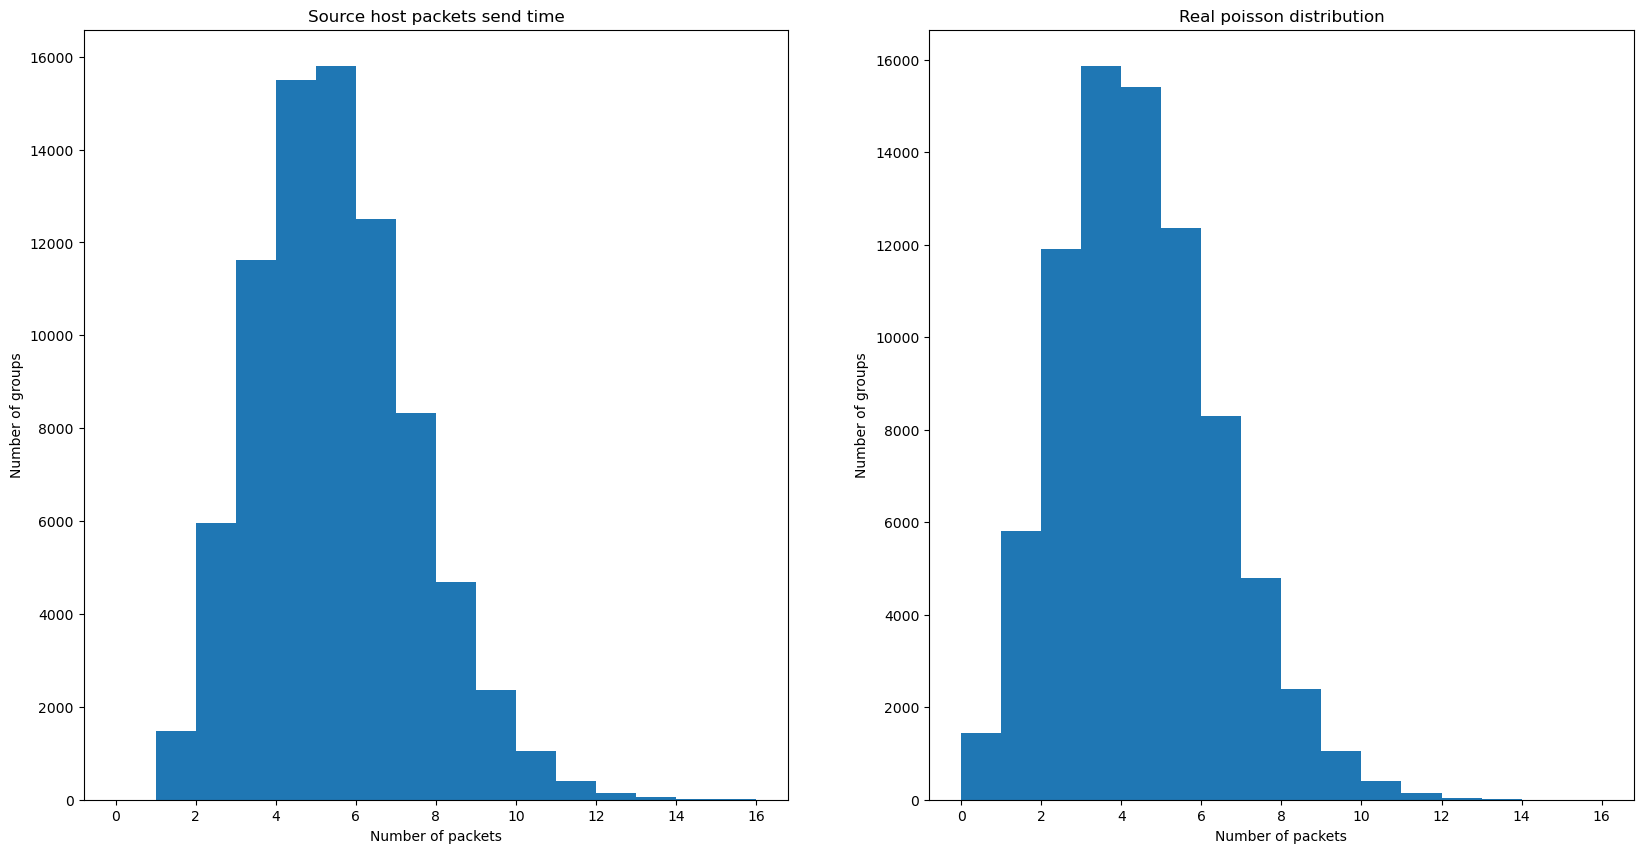

In [16]:
# FIFO

fifo_send_interarrival_time = get_packets_send_interarrival_time(fifo_source_host.packets)
fifo_send_interarrival_time_poisson = get_poisson_from_exponential(fifo_send_interarrival_time)
print(f'FIFO number of samples is {len(fifo_send_interarrival_time_poisson)}')

real_poisson = poisson.rvs(SOURCE_HOST_LAMBDA, size=len(fifo_send_interarrival_time_poisson))
print('As we can see the source host number of packets is following poisson distribution.\n'
      '(source host packets\' interarrival time follows exponential distribution.)')
draw_two_hists_to_compare(fifo_send_interarrival_time_poisson, real_poisson, 'Source host packets send time', 'Real poisson distribution', 'Number of packets', 'Number of groups')

WRR number of samples is 79864
As we can see the source host packets send time is following poisson distribution.
(source host packets' interarrival time follows exponential distribution.)


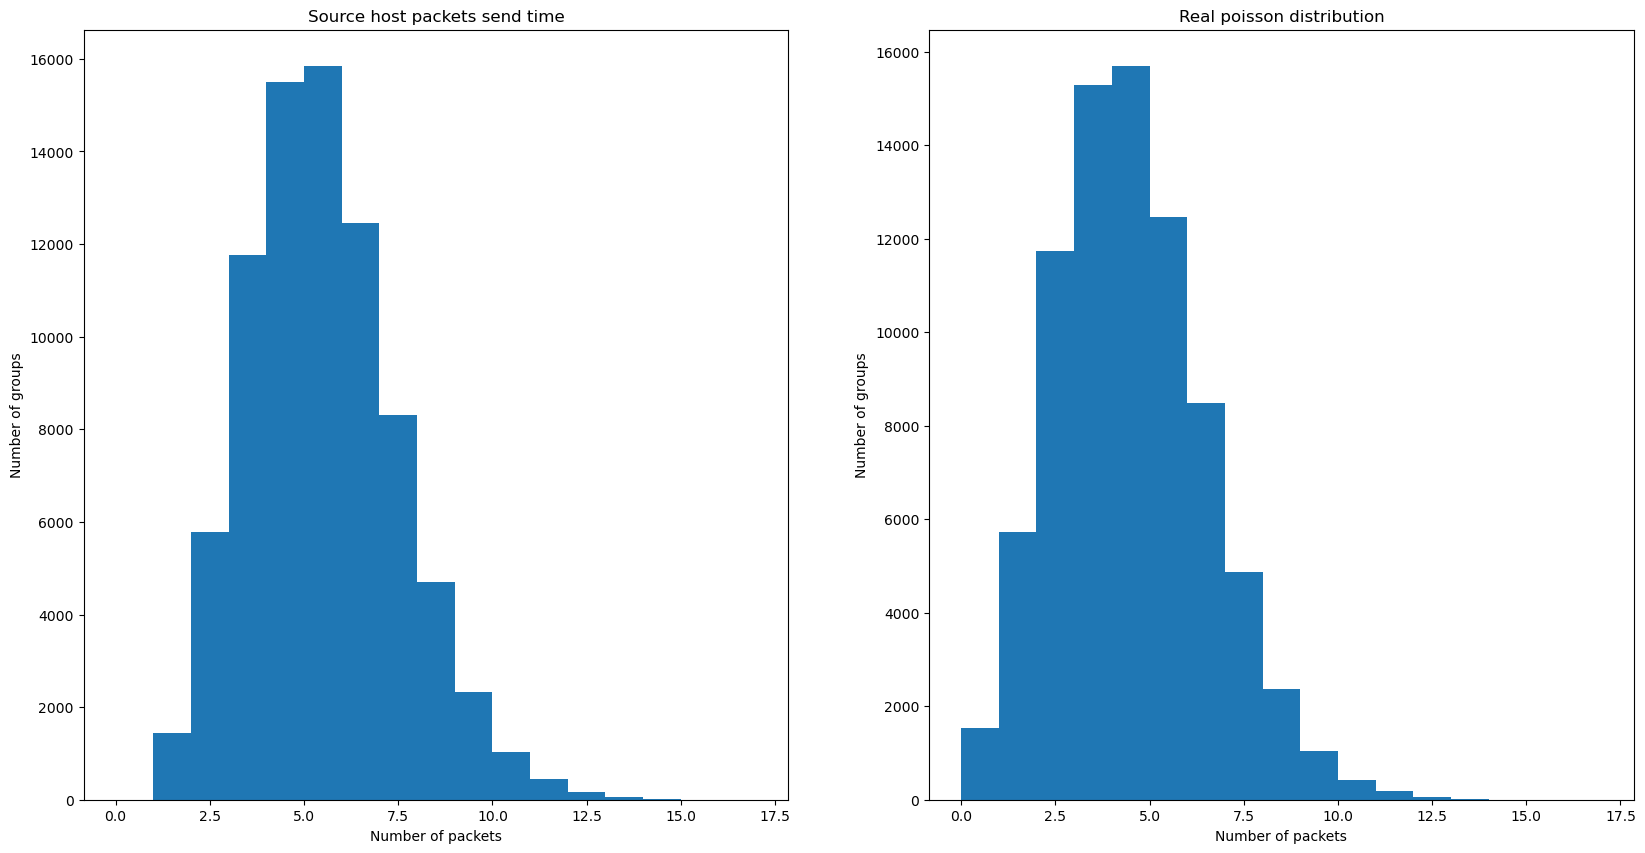

In [17]:
# WRR

wrr_send_interarrival_time = get_packets_send_interarrival_time(wrr_source_host.packets)
wrr_send_interarrival_time_poisson = get_poisson_from_exponential(wrr_send_interarrival_time)
print(f'WRR number of samples is {len(wrr_send_interarrival_time_poisson)}')

real_poisson = poisson.rvs(SOURCE_HOST_LAMBDA, size=len(wrr_send_interarrival_time_poisson))
print('As we can see the source host packets send time is following poisson distribution.\n'
      '(source host packets\' interarrival time follows exponential distribution.)')
draw_two_hists_to_compare(wrr_send_interarrival_time_poisson, real_poisson, 'Source host packets send time', 'Real poisson distribution', 'Number of packets', 'Number of groups')

NPPS number of samples is 80010
As we can see the source host packets send time is following poisson distribution.
(source host packets' interarrival time follows exponential distribution.)


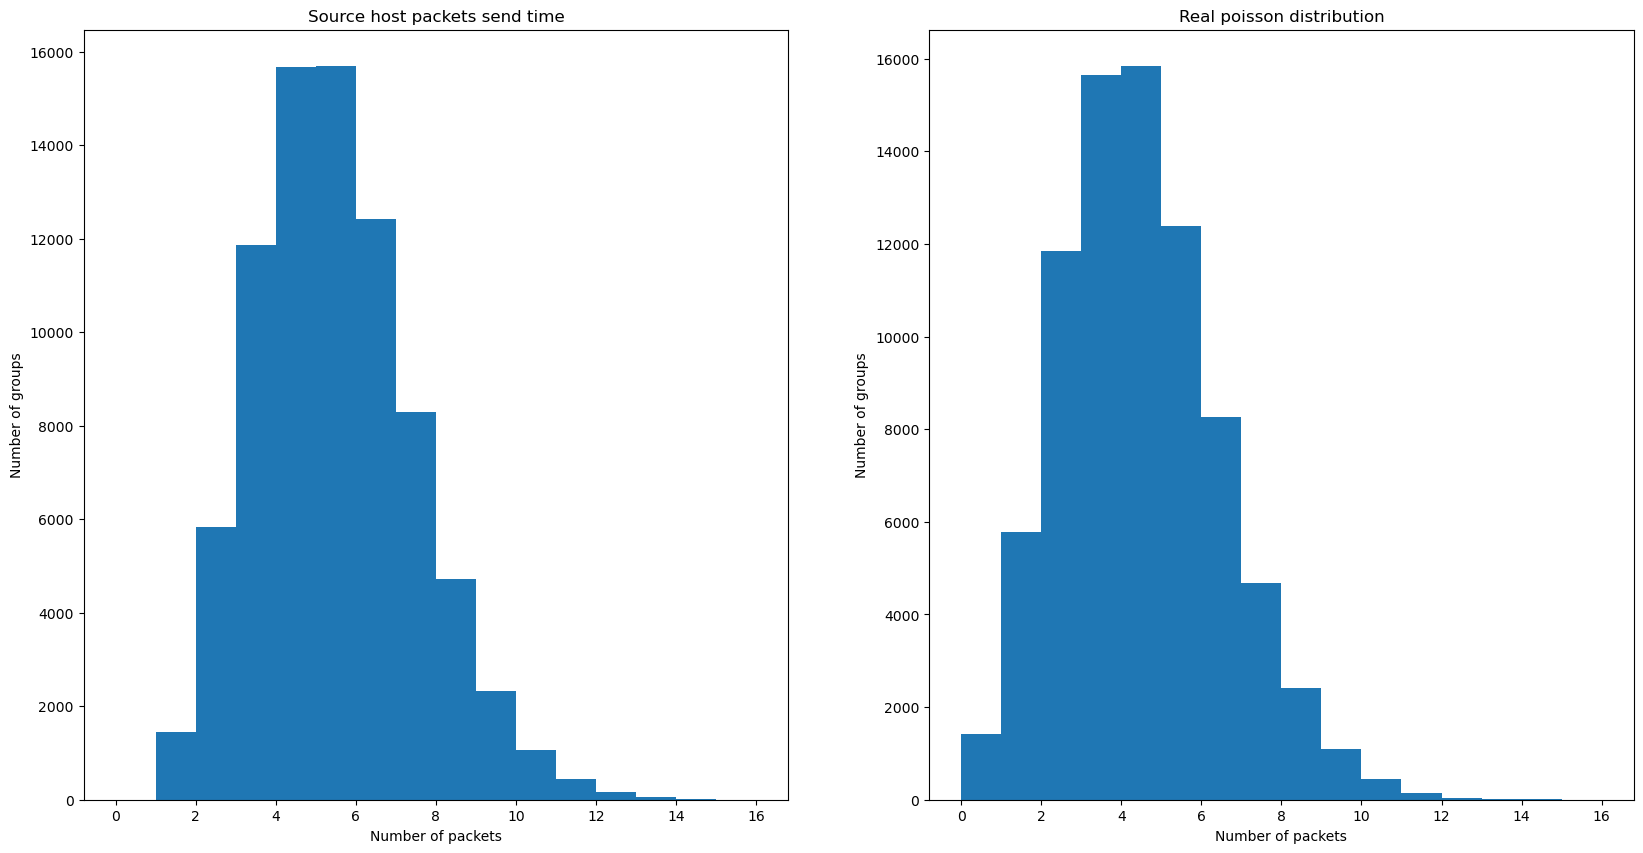

In [18]:
# NPPS

npps_send_interarrival_time = get_packets_send_interarrival_time(npps_source_host.packets)
npps_send_interarrival_time_poisson = get_poisson_from_exponential(npps_send_interarrival_time)
print(f'NPPS number of samples is {len(npps_send_interarrival_time_poisson)}')

real_poisson = poisson.rvs(SOURCE_HOST_LAMBDA, size=len(npps_send_interarrival_time_poisson))
print('As we can see the source host packets send time is following poisson distribution.\n'
      '(source host packets\' interarrival time follows exponential distribution.)')
draw_two_hists_to_compare(npps_send_interarrival_time_poisson, real_poisson, 'Source host packets send time', 'Real poisson distribution', 'Number of packets', 'Number of groups')

## Confirm that router exponential distribution follows the real one

In [19]:
def get_packets_process_time(packets):
    router_packet_process_times = []
    for packet in packets:
        process_time = packet.process_time
        if process_time is None:
            continue

        router_packet_process_times.append(process_time)

    return router_packet_process_times

FIFO number of samples is 330537
As we can see the router packets process time is following exponential distribution.


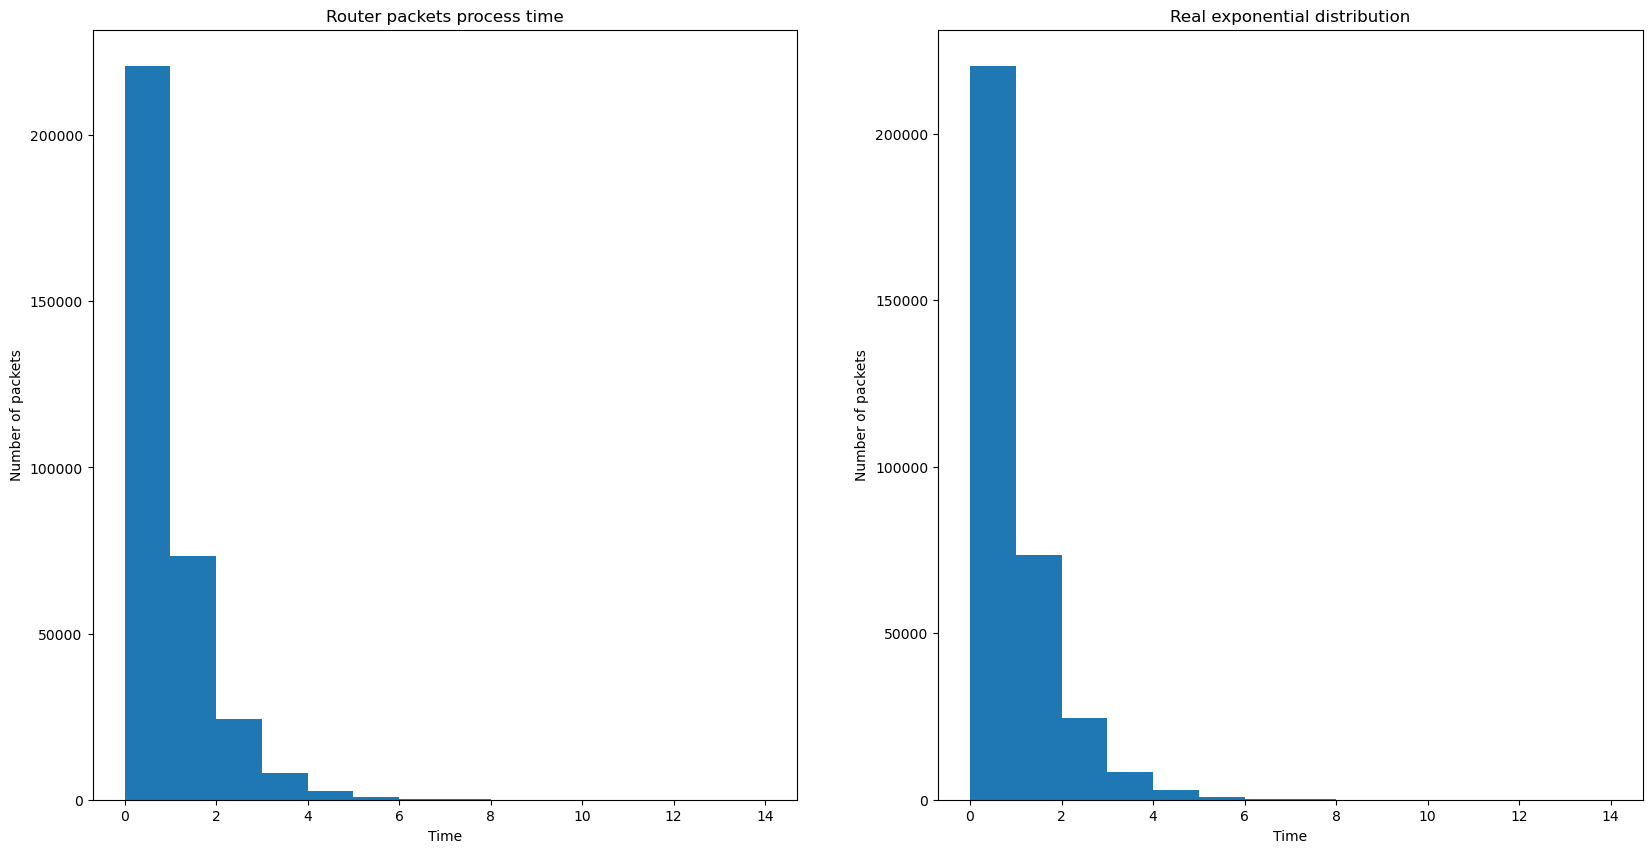

In [20]:
# FIFO

fifo_packets_process_time = get_packets_process_time(fifo_source_host.packets)
print(f'FIFO number of samples is {len(fifo_packets_process_time)}')

real_exponential = expon.rvs(scale=1 / ROUTER_PROCESS_TIME_LAMBDA, size=len(fifo_packets_process_time))
print('As we can see the router packets process time is following exponential distribution.')
draw_two_hists_to_compare(fifo_packets_process_time, real_exponential, 'Router packets process time', 'Real exponential distribution', 'Time', 'Number of packets')

WRR number of samples is 329571
As we can see the router packets process time is following exponential distribution.


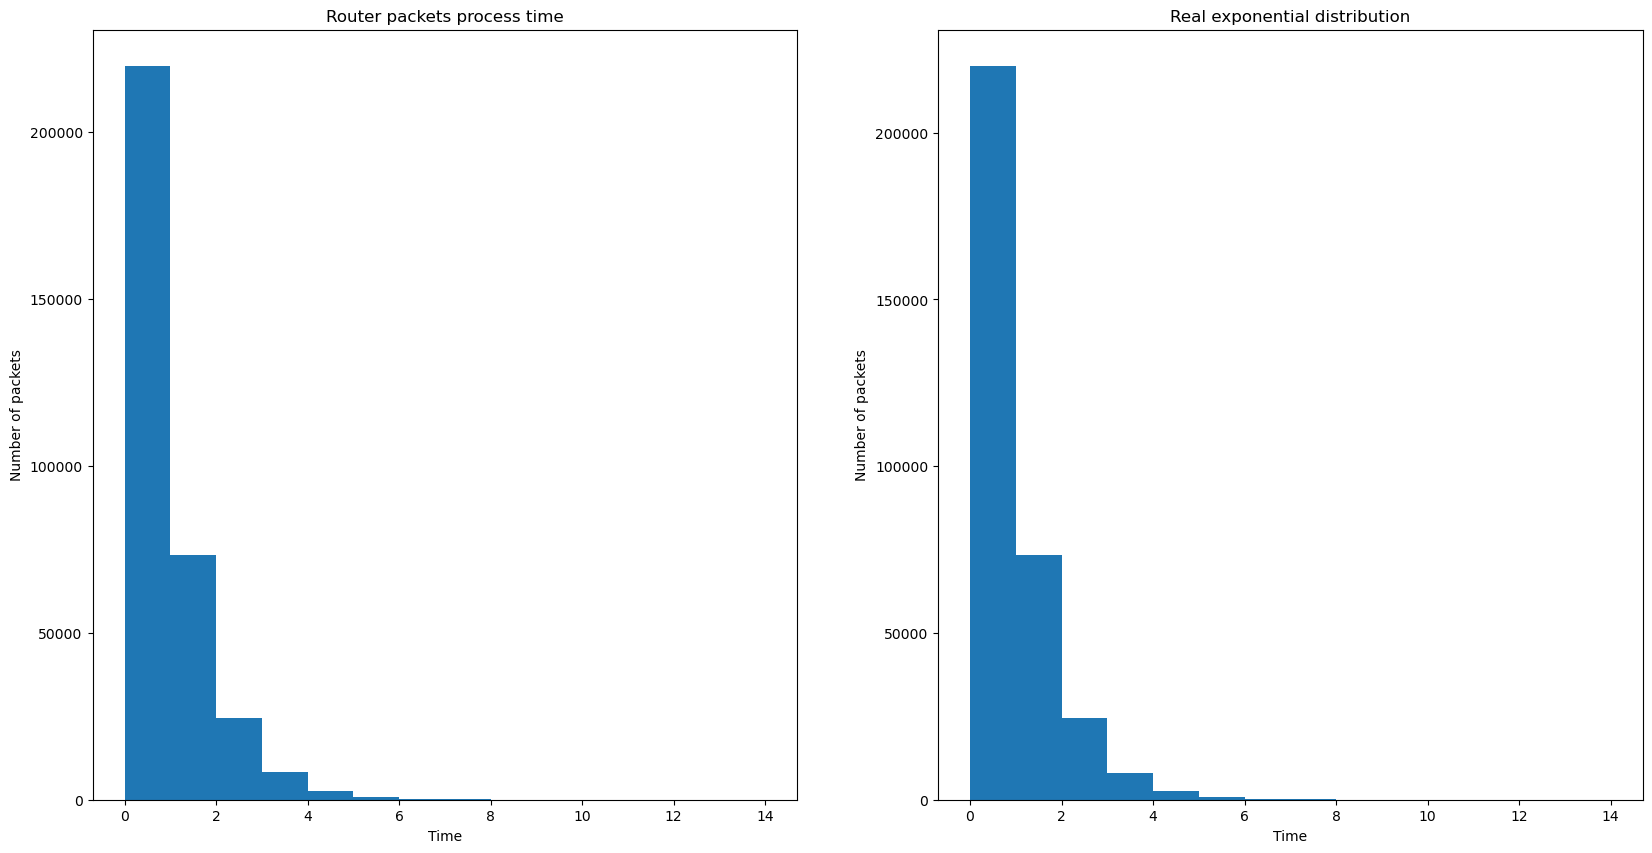

In [21]:
# WRR

wrr_packets_process_time = get_packets_process_time(wrr_source_host.packets)
print(f'WRR number of samples is {len(wrr_packets_process_time)}')

real_exponential = expon.rvs(scale=1 / ROUTER_PROCESS_TIME_LAMBDA, size=len(wrr_packets_process_time))
print('As we can see the router packets process time is following exponential distribution.')
draw_two_hists_to_compare(wrr_packets_process_time, real_exponential, 'Router packets process time', 'Real exponential distribution', 'Time', 'Number of packets')

NPPS number of samples is 329729
As we can see the router packets process time is following exponential distribution.


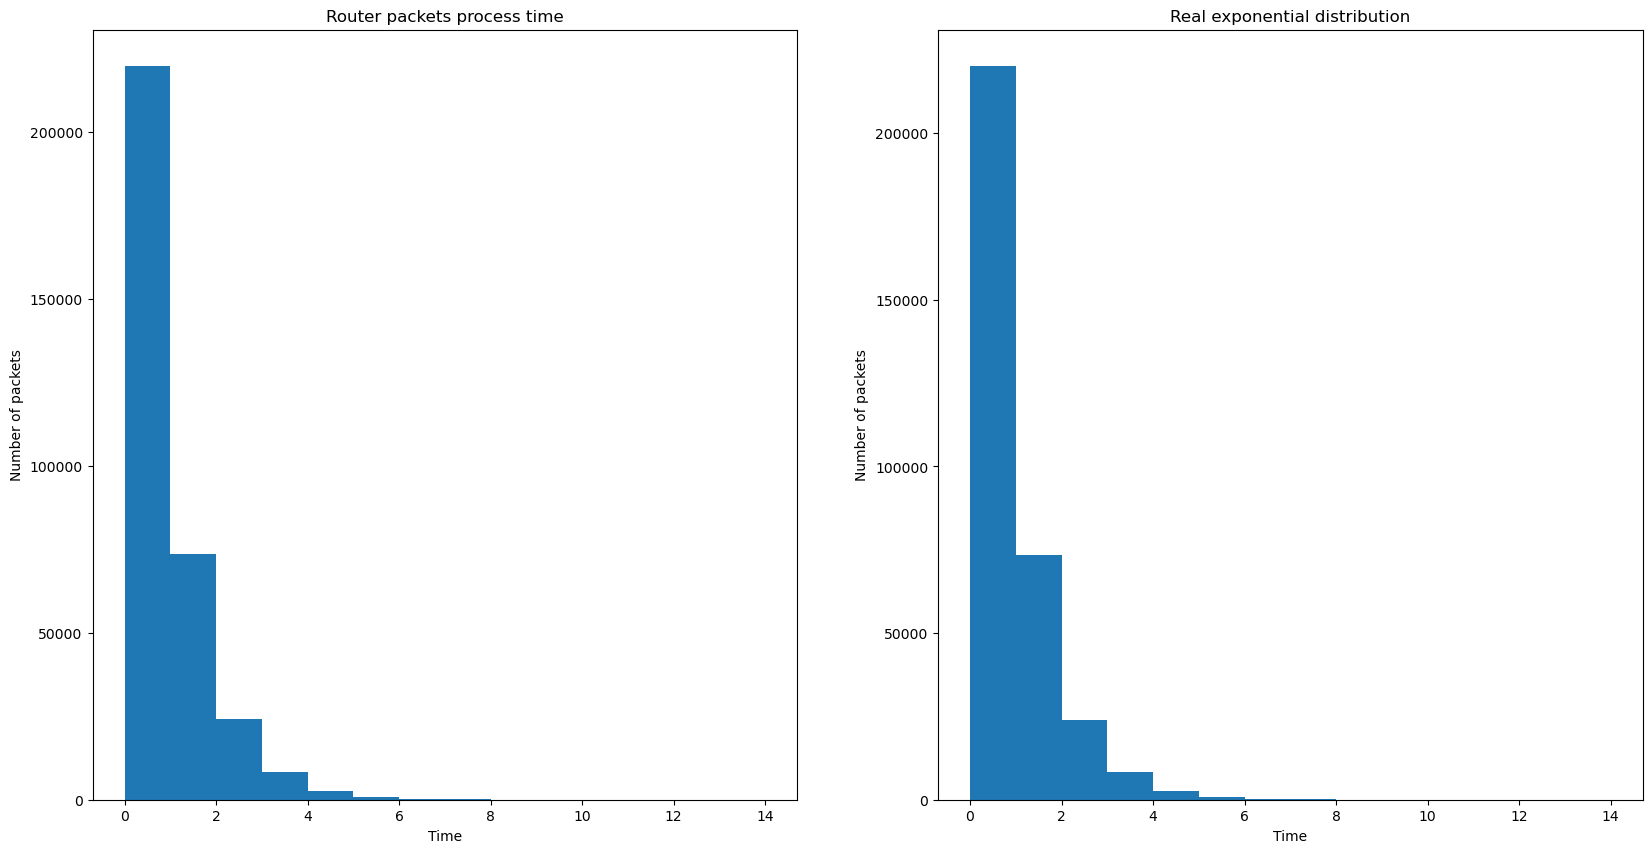

In [22]:
# NPPS

npps_packets_process_time = get_packets_process_time(npps_source_host.packets)
print(f'NPPS number of samples is {len(npps_packets_process_time)}')

real_exponential = expon.rvs(scale=1 / ROUTER_PROCESS_TIME_LAMBDA, size=len(npps_packets_process_time))
print('As we can see the router packets process time is following exponential distribution.')
draw_two_hists_to_compare(npps_packets_process_time, real_exponential, 'Router packets process time', 'Real exponential distribution', 'Time', 'Number of packets')

In [23]:
print('Strongly Confirmed!')

Strongly Confirmed!


# Main Reports

In [24]:
def get_average(my_list):
    return sum(my_list) / len(my_list)

## Average length of queues

In [25]:
# FIFO

fifo_queue_length_log = fifo_router.queue.queue_length_log
fifo_average_queue_length = get_average(fifo_queue_length_log)
print(f'FIFO average queue length is {fifo_average_queue_length}.')

FIFO average queue length is 94.62289216413056.


In [26]:
# WRR - EACH

wrr_queue_length_log = wrr_router.queue.queues_length_log
wrr_average_queue_length = []
for i in range(len(wrr_queue_length_log)):
    wrr_average_queue_length.append(get_average(wrr_queue_length_log[i]))

print(f'WRR average queue length is {wrr_average_queue_length}, from the lowest priority to the highest priority.')

WRR average queue length is [95.43944790910174, 2.5820570941057404, 0.8291279160795365], from the lowest priority to the highest priority.


In [27]:
# WRR - ALL

wrr_all_queues_length_log = []
for i in range(len(wrr_queue_length_log)):
    wrr_all_queues_length_log += wrr_queue_length_log[i]

wrr_all_queues_length_average = get_average(wrr_all_queues_length_log)
print(f'WRR average queues length is {wrr_all_queues_length_average}.')

WRR average queues length is 38.82584107696697.


In [28]:
# NPPS

npps_queue_length_log = npps_router.queue.queue_length_log
npps_average_queue_length = get_average(npps_queue_length_log)
print(f'NPPS average queue length is {npps_average_queue_length}.')

NPPS average queue length is 94.83657866679204.


In [29]:
# ALL

all_queues_length_average = [fifo_average_queue_length] + wrr_average_queue_length + [npps_average_queue_length]
all_queues_length_average = get_average(all_queues_length_average)
print(f'ALL average queue length is {all_queues_length_average}.')

ALL average queue length is 57.66202075004192.


# Average waiting time in queues

In [30]:
def get_waiting_times(packets):
    waiting_times = []
    for packet in packets:
        waiting_time = packet.start_process_time - packet.wait_enqueue_time
        if waiting_time < 0:
            raise ValueError(f'Waiting time is negative for packet {packet.id}, '
                             f'start_process_time is {packet.start_process_time}, wait_enqueue_time is {packet.wait_enqueue_time}')

        waiting_times.append(waiting_time)

    return waiting_times

In [31]:
# FIFO

fifo_waiting_times = get_waiting_times(fifo_destination_host.packets)
fifo_average_waiting_time = get_average(fifo_waiting_times)
print(f'FIFO average waiting time is {fifo_average_waiting_time}.')

FIFO average waiting time is 28.780607098846215.


In [32]:
# WRR - EACH

number_of_queues = len(wrr_router.queue.queues)
each_queue_packets = [[] for _ in range(number_of_queues)]
for packet in wrr_destination_host.packets:
    each_queue_packets[packet.priority - 1].append(packet)

wrr_waiting_times = []
for i in range(number_of_queues):
    wrr_waiting_times.append(get_waiting_times(each_queue_packets[i]))

wrr_average_waiting_time = []
for i in range(number_of_queues):
    wrr_average_waiting_time.append(get_average(wrr_waiting_times[i]))

print(f'WRR average waiting time is {wrr_average_waiting_time}, from the lowest priority to the highest priority.')

WRR average waiting time is [74.28175803120878, 1.7507630481965957, 0.48772118943783166], from the lowest priority to the highest priority.


In [33]:
# WRR - ALL

wrr_all_waiting_times = []
for i in range(number_of_queues):
    wrr_all_waiting_times += wrr_waiting_times[i]

wrr_all_average_waiting_time = get_average(wrr_all_waiting_times)
print(f'WRR average waiting time is {wrr_all_average_waiting_time}.')

WRR average waiting time is 30.0802075463505.


In [34]:
# NPPS

npps_waiting_times = get_waiting_times(npps_destination_host.packets)
npps_average_waiting_time = get_average(npps_waiting_times)
print(f'NPPS average waiting time is {npps_average_waiting_time}.')

NPPS average waiting time is 12.529125708488758.


In [35]:
# ALL

all_waiting_times = fifo_waiting_times + wrr_all_waiting_times + npps_waiting_times
all_average_waiting_time = get_average(all_waiting_times)
print(f'ALL average waiting time is {all_average_waiting_time}.')

ALL average waiting time is 23.79973410328432.


## Utilization of the processors

In [36]:
def get_utilization(packets):
    global T

    processors_packets = [[] for _ in range(PROCESSORS_NUMBER)]
    for packet in packets:
        processors_packets[packet.processor_number].append(packet)

    processors_utilization = []
    for i in range(PROCESSORS_NUMBER):
        current_processor_packets = processors_packets[i]
        current_processor_utilization = sum([packet.process_time for packet in current_processor_packets]) / T
        processors_utilization.append(current_processor_utilization)

    return processors_utilization

In [37]:
# FIFO

fifo_processors_utilization = get_utilization(fifo_destination_host.packets)

print(f'FIFO processors utilization is {fifo_processors_utilization}.')
print(f'FIFO average processors utilization is {get_average(fifo_processors_utilization)}.')

FIFO processors utilization is [0.9999962865308347, 0.999989511339167, 0.999997203754473].
FIFO average processors utilization is 0.9999943338748248.


In [38]:
# WRR

wrr_processors_utilization = get_utilization(wrr_destination_host.packets)

print(f'WRR processors utilization is {wrr_processors_utilization}.')
print(f'WRR average processors utilization is {get_average(wrr_processors_utilization)}.')

WRR processors utilization is [1.000001912508682, 0.9999952241178087, 0.9999678234360864].
WRR average processors utilization is 0.9999883200208591.


In [39]:
# NPPS

npps_processors_utilization = get_utilization(npps_destination_host.packets)

print(f'NPPS processors utilization is {npps_processors_utilization}.')
print(f'NPPS average processors utilization is {get_average(npps_processors_utilization)}.')

NPPS processors utilization is [0.9999971018235579, 0.999991271060118, 0.9999921376863281].
NPPS average processors utilization is 0.9999935035233346.


In [40]:
# ALL

all_processors_utilization = fifo_processors_utilization + wrr_processors_utilization + npps_processors_utilization
all_processors_utilization_average = get_average(all_processors_utilization)
print(f'ALL processors utilization average is {all_processors_utilization_average}.')

ALL processors utilization average is 0.9999920524730062.


### How can we increase the utilization of the processors?

Currently, I think the utilization is good, overall. But still, there are some methods we can use to increase the utilization:
- If we have access to the source host and if we can, increase the rate of sending packets from the source host!
- We can use faster processors with a lower rate of processing packets. (an exponential distribution with lower lambda)
- Based on benchmarks, the WRR scheduling algorithm is better than the others, so we can use it instead of FIFO or NPPS. Or if there is another better scheduling algorithm, we can use it.
- If we have enough input packets, increasing the number of processors can be a good idea.
- Increasing the number of processors can reduce the waiting time in queues and number of dropped packets, so it can increase the utilization of the processors.

## Number of dropped packets

In [41]:
# FIFO

fifo_dropped_packets = fifo_router.drops
print(f'FIFO dropped packets number is {len(fifo_dropped_packets)}.')

FIFO dropped packets number is 68550.


In [42]:
# WRR

wrr_dropped_packets = wrr_router.drops
print(f'WRR dropped packets number is {len(wrr_dropped_packets)}.')

WRR dropped packets number is 69756.


In [43]:
# NPPS

npps_dropped_packets = npps_router.drops
print(f'NPPS dropped packets number is {len(npps_dropped_packets)}.')

NPPS dropped packets number is 69805.


In [44]:
# ALL

all_dropped_packets = fifo_dropped_packets + wrr_dropped_packets + npps_dropped_packets
print(f'ALL dropped packets number is {len(all_dropped_packets)}.')

ALL dropped packets number is 208111.


## CDF of the waiting time in queues for high priority packets

In [56]:
def get_high_priority_packets(packets):
    high_priority_packets = []
    for packet in packets:
        if packet.priority == 3:
            high_priority_packets.append(packet)

    return high_priority_packets

def get_waiting_times_for_high_priority_packets(packets):
    high_priority_packets = get_high_priority_packets(packets)
    return get_waiting_times(high_priority_packets)

# https://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python
def draw_cdf(waiting_times, title):
    waiting_times.sort()
    y = np.arange(len(waiting_times))/float(len(waiting_times)-1)
    plt.plot(waiting_times, y)
    plt.title(title)
    plt.xlabel('Waiting time')
    plt.ylabel('CDF')

    plt.show()

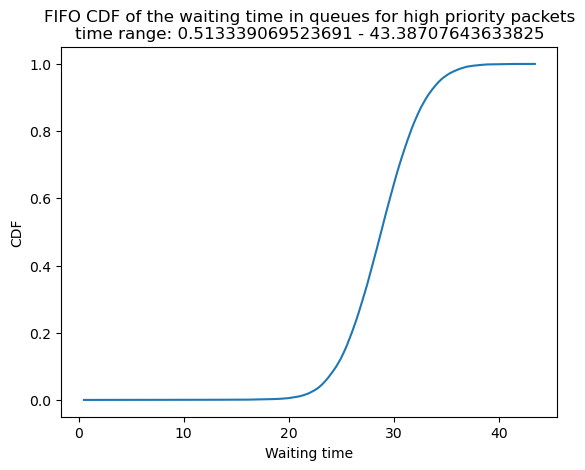

In [57]:
# FIFO

fifo_high_priority_waiting_times = get_waiting_times_for_high_priority_packets(fifo_destination_host.packets)
draw_cdf(fifo_high_priority_waiting_times, f'FIFO CDF of the waiting time in queues for high priority packets\n'
                                           f'time range: '
                                           f'{min(fifo_high_priority_waiting_times)} - {max(fifo_high_priority_waiting_times)}')

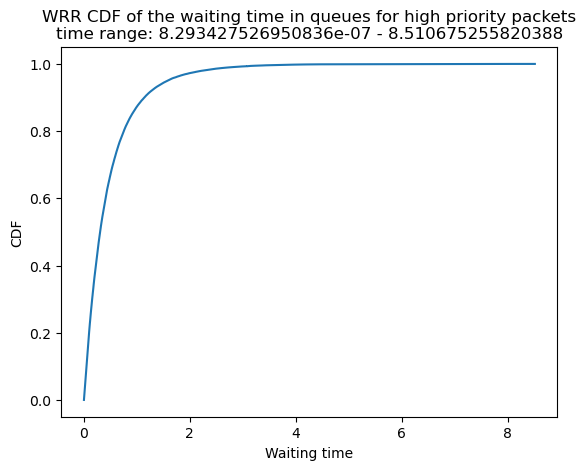

In [58]:
# WRR

wrr_high_priority_waiting_times = get_waiting_times_for_high_priority_packets(wrr_destination_host.packets)
draw_cdf(wrr_high_priority_waiting_times, f'WRR CDF of the waiting time in queues for high priority packets\n'
                                          f'time range: '
                                          f'{min(wrr_high_priority_waiting_times)} - {max(wrr_high_priority_waiting_times)}')

In [59]:
print(f'Practically it\'s just for the high priority queue of the WRR. In the other queues, there is not any packet with '
      f'high priority.')

Practically it's just for the high priority queue of the WRR. In the other queues, there is not any packet with high priority.


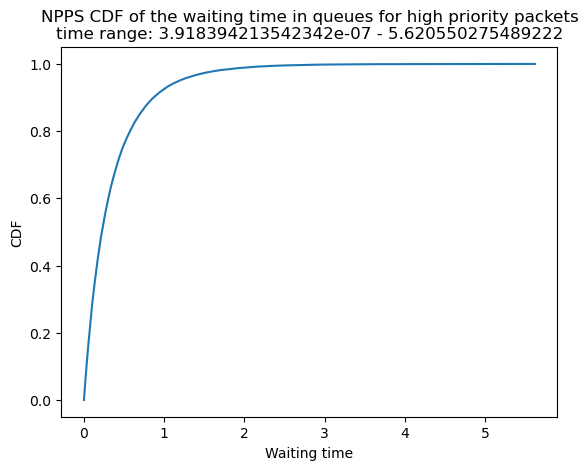

In [60]:
# NPPS

npps_high_priority_waiting_times = get_waiting_times_for_high_priority_packets(npps_destination_host.packets)
draw_cdf(npps_high_priority_waiting_times, f'NPPS CDF of the waiting time in queues for high priority packets\n'
                                           f'time range: '
                                           f'{min(npps_high_priority_waiting_times)} - {max(npps_high_priority_waiting_times)}')

In [61]:
def draw_cdf_not_show(waiting_times):
    waiting_times.sort()
    yvals=np.arange(len(waiting_times))/float(len(waiting_times)-1)
    plt.plot(waiting_times, yvals)
    plt.xlabel('Waiting time')
    plt.ylabel('CDF')

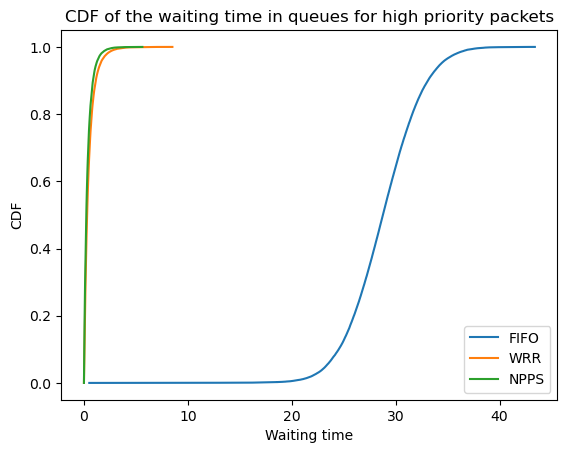

In [62]:
# FIFO vs. WRR vs. NPPS

draw_cdf_not_show(fifo_high_priority_waiting_times)
draw_cdf_not_show(wrr_high_priority_waiting_times)
draw_cdf_not_show(npps_high_priority_waiting_times)

plt.title('CDF of the waiting time in queues for high priority packets')
plt.legend(['FIFO', 'WRR', 'NPPS'])
plt.show()

## Received number of packets for destination host

In [63]:
# FIFO

fifo_received_packets = len(fifo_destination_host.packets)
fifo_sent_packets = len(fifo_source_host.packets)

print(f'FIFO received packets number is {fifo_received_packets}.')
print(f'It\'s {fifo_received_packets / fifo_sent_packets} of the sent packets.')

FIFO received packets number is 330451.
It's 0.8280153750551257 of the sent packets.


In [64]:
# WRR

wrr_received_packets = len(wrr_destination_host.packets)
wrr_send_packets = len(wrr_source_host.packets)

print(f'WRR received packets number is {wrr_received_packets}.')
print(f'It\'s {wrr_received_packets / wrr_send_packets} of the sent packets.')

WRR received packets number is 329465.
It's 0.8250485816171168 of the sent packets.


In [65]:
# NPPS

npps_received_packets = len(npps_destination_host.packets)
npps_send_packets = len(npps_source_host.packets)

print(f'NPPS received packets number is {npps_received_packets}.')
print(f'It\'s {npps_received_packets / npps_send_packets} of the sent packets.')

NPPS received packets number is 329630.
It's 0.825036167134712 of the sent packets.


## Choose the best scheduling algorithm

Based on the told criteria (number of dropped packets and the percentage of received packets), the FIFO algorithm is the best. In both criteria, it has the best results (68550 dropped packets and 82.80153750551257% received packets).
After that, the better one is WRR and the worst one is NPPS. WRR acts better in both criteria than NPPS. It has 69756 dropped packets and 82.50485816171168% received packets while NPPS has 69805 dropped packets and 82.5036167134712% received packets.